# AXA Coding Challenge
Author: Jonas Mickel

# Imports & Globals

In [1]:
#system
import re
import os
import zipfile
from io import BytesIO
from glob import glob
from datetime import date
from typing import Dict, List, Tuple

#3rd party
import boto3
import folium
import numpy as np
import polars as pl
import pandas as pd 
import geopandas as gpd
import xgboost as xgb

from botocore.client import Config
from botocore import UNSIGNED

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from folium.plugins import HeatMap

from citibike_utils import *

SEED=2024
YEAR_OF_INTEREST=2024

pl.enable_string_cache()

## Load 2024 trip data from s3

In [2]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
BUCKET_NAME = 'tripdata'
response = s3.list_objects_v2(Bucket=BUCKET_NAME)

if 'Contents' in response:
    filtered_trip_data = [obj['Key'] for obj in response['Contents'] if re.search(rf'{YEAR_OF_INTEREST}', obj['Key'])]

In [3]:
filtered_trip_data

['202401-citibike-tripdata.csv.zip',
 '202402-citibike-tripdata.csv.zip',
 '202403-citibike-tripdata.csv.zip',
 '202404-citibike-tripdata.csv.zip',
 '202405-citibike-tripdata.zip',
 '202406-citibike-tripdata.zip',
 '202407-citibike-tripdata.zip',
 '202408-citibike-tripdata.zip',
 '202409-citibike-tripdata.zip',
 '202410-citibike-tripdata.zip',
 'JC-202401-citibike-tripdata.csv.zip',
 'JC-202402-citibike-tripdata.csv.zip',
 'JC-202403-citibike-tripdata.csv.zip',
 'JC-202404-citibike-tripdata.csv.zip',
 'JC-202405-citibike-tripdata.csv.zip',
 'JC-202406-citibike-tripdata.csv.zip',
 'JC-202407-citibike-tripdata.csv.zip',
 'JC-202408-citibike-tripdata.csv.zip',
 'JC-202409-citibike-tripdata.csv.zip',
 'JC-202410-citibike-tripdata.csv.zip']

In [4]:
def s3_trip_download(bucket_name: str, file_key: str, path_prefix: str) -> None:
    """
    Downloads CitiBike tripdata to local storage
    """
    key_basename = file_key.split('.')[0]
    if not key_basename in ';'.join(os.listdir(path_prefix)):
        try:
            s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
        except Exception as e:
            print(e)
            return None
        with zipfile.ZipFile(BytesIO(s3_object['Body'].read())) as z:
            print(z.namelist())
            csv_list = list(filter(lambda x: x.endswith('.csv') and x.startswith(key_basename), z.namelist()))
            for csv in csv_list:
                with z.open(csv) as csv_file:
                    with open(f'{path_prefix}/{os.path.basename(csv)}', 'wb') as f:
                        f.write(csv_file.read())
    
def s3_to_pandas(bucket_name: str, file_key: str, idx: int, nrows: int) -> pd.DataFrame:
    """
    Downloads CitiBike tripdata to pd.DataFrame in memory.
    """
    print(idx, file_key)
    s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
    with zipfile.ZipFile(BytesIO(s3_object['Body'].read())) as z:
        print(z.namelist())
        csv_list = list(filter(lambda x: x.endswith('.csv') and x.startswith(file_key.split('.')[0]), z.namelist()))
        if csv_list:
            print(csv_list)
            df_list = []
            for csv in csv_list:
                with z.open(csv) as csv_file:
                    df_list.append(pd.read_csv(csv_file, nrows=nrows))
            return pd.concat(df_list)
        else:
            return pd.DataFrame() 

for idx, key in enumerate(filtered_trip_data):
    print(idx, key)
    s3_trip_download(BUCKET_NAME, key, 'data')

0 202401-citibike-tripdata.csv.zip
1 202402-citibike-tripdata.csv.zip
2 202403-citibike-tripdata.csv.zip
3 202404-citibike-tripdata.csv.zip
4 202405-citibike-tripdata.zip
5 202406-citibike-tripdata.zip
6 202407-citibike-tripdata.zip
7 202408-citibike-tripdata.zip
8 202409-citibike-tripdata.zip
9 202410-citibike-tripdata.zip
10 JC-202401-citibike-tripdata.csv.zip
11 JC-202402-citibike-tripdata.csv.zip
12 JC-202403-citibike-tripdata.csv.zip
13 JC-202404-citibike-tripdata.csv.zip
14 JC-202405-citibike-tripdata.csv.zip
15 JC-202406-citibike-tripdata.csv.zip
16 JC-202407-citibike-tripdata.csv.zip
17 JC-202408-citibike-tripdata.csv.zip
18 JC-202409-citibike-tripdata.csv.zip
19 JC-202410-citibike-tripdata.csv.zip


In [5]:
# read only 100 rows to get a understanding of available columns across files
trip_df_sample = pd.concat([pd.read_csv(csv, nrows=10) for csv in glob(r'data/*tripdata*.csv')])

In [6]:
trip_df_sample.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Unnamed: 0,rideable_type_duplicate_column_name_1
0,5078F3D302000BD2,electric_bike,2024-01-22 18:43:19.012,2024-01-22 18:48:10.708,Frederick Douglass Blvd & W 145 St,7954.12,St Nicholas Ave & W 126 St,7756.1,40.823072,-73.941738,40.811432,-73.951878,member,NaN,NaN
1,814337105D37302A,electric_bike,2024-01-11 19:19:18.721,2024-01-11 19:47:36.007,W 54 St & 6 Ave,6771.13,E 74 St & 1 Ave,6953.08,40.761822,-73.977036,40.768974,-73.954823,member,NaN,NaN
2,A33A920E2B10710C,electric_bike,2024-01-30 19:17:41.693,2024-01-30 19:32:49.857,E 11 St & Ave B,5659.11,W 10 St & Washington St,5847.06,40.727592,-73.979751,40.733424,-74.008515,casual,NaN,NaN
3,A3A5FC0DD7D34D74,electric_bike,2024-01-27 11:27:01.759,2024-01-27 11:38:01.213,W 54 St & 6 Ave,6771.13,E 74 St & 1 Ave,6953.08,40.761779,-73.977144,40.768974,-73.954823,member,NaN,NaN
4,6F96728ECEFBDAA4,electric_bike,2024-01-16 15:15:41.000,2024-01-16 15:29:26.156,Madison Ave & E 99 St,7443.01,E 74 St & 1 Ave,6953.08,40.789808,-73.952214,40.768974,-73.954823,member,NaN,NaN


In [7]:
trip_df_sample.describe()

,start_lat,start_lng,end_lat,end_lng,Unnamed: 0
count,450.000000,450.000000,450.000000,450.000000,5.000000e+01
mean,40.741656,-73.985004,40.741029,-73.984166,2.000004e+06
std,0.039772,0.041871,0.038498,0.040484,1.428571e+06
min,40.648005,-74.072009,40.637033,-74.071959,0.000000e+00
25%,40.718075,-74.007889,40.719252,-74.009137,1.000002e+06
50%,40.739814,-73.985030,40.738177,-73.985637,2.000004e+06
75%,40.756277,-73.958722,40.756765,-73.957848,3.000007e+06
max,40.875531,-73.859204,40.879350,-73.864540,4.000009e+06


In [8]:
# check if there is mismatched data in columns rideable_type and its duplicate
print(trip_df_sample.rideable_type.value_counts())
print(trip_df_sample.rideable_type_duplicate_column_name_1.value_counts())
trip_df_sample[trip_df_sample.rideable_type_duplicate_column_name_1.notna()].query("""rideable_type_duplicate_column_name_1!=rideable_type""")
# -> can be disregarded, duplicated

rideable_type
electric_bike    310
classic_bike     140
Name: count, dtype: int64
rideable_type_duplicate_column_name_1
electric_bike    32
classic_bike     18
Name: count, dtype: int64


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Unnamed: 0,rideable_type_duplicate_column_name_1


In [9]:
# check 'unnamed column' 
trip_df_sample.iloc[:,14].value_counts()

rideable_type_duplicate_column_name_1
electric_bike    32
classic_bike     18
Name: count, dtype: int64

In [10]:
trip_df_sample[trip_df_sample.iloc[:,14].notna()]
# seems to be only contained in July entries
# corresponds to row number, data seems to be chunked in files of 1M rows each
# -> can be disregarded

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Unnamed: 0,rideable_type_duplicate_column_name_1
0,7751B52D3787C04F,classic_bike,2024-08-17 11:42:14.451,2024-08-17 11:55:24.856,5 Ave & E 87 St,7323.09,5 Ave & E 63 St,6904.06,40.782323,-73.959875,40.766368,-73.971518,casual,NaN,classic_bike
1,D55E8D998FAB6749,classic_bike,2024-08-17 11:42:06.786,2024-08-17 11:55:30.094,5 Ave & E 87 St,7323.09,5 Ave & E 63 St,6904.06,40.782323,-73.959875,40.766368,-73.971518,casual,NaN,classic_bike
2,0477812DB65BF3FB,electric_bike,2024-08-22 07:18:43.412,2024-08-22 07:40:48.249,E 53 St & Madison Ave,6659.03,Lenox Ave & W 117 St,7655.22,40.759711,-73.974023,40.802557,-73.949078,casual,NaN,electric_bike
3,E2E8A247831D3463,electric_bike,2024-08-21 17:59:51.350,2024-08-21 18:24:22.388,E 53 St & Madison Ave,6659.03,Lenox Ave & W 130 St,7753.13,40.759711,-73.974023,40.810792,-73.943068,casual,NaN,electric_bike
4,3BA2B12245849ECD,classic_bike,2024-08-23 12:48:30.734,2024-08-23 13:46:11.632,MacDougal St & Washington Sq,5797.01,Lafayette St & Grand St,5422.09,40.732264,-73.998522,40.720280,-73.998790,casual,NaN,classic_bike
5,ADBAD6489631209E,electric_bike,2024-08-27 19:00:01.861,2024-08-27 19:06:41.245,MacDougal St & Washington Sq,5797.01,Lafayette St & Grand St,5422.09,40.732264,-73.998522,40.720280,-73.998790,casual,NaN,electric_bike
6,333B09F497DA03C2,classic_bike,2024-08-31 14:49:04.668,2024-08-31 15:41:46.802,5 Ave & E 87 St,7323.09,5 Ave & E 63 St,6904.06,40.782323,-73.959875,40.766368,-73.971518,casual,NaN,classic_bike
7,80FCD62A5676B480,classic_bike,2024-08-17 11:04:52.140,2024-08-17 11:32:20.506,Broadway & E 19 St,5980.11,5 Ave & E 63 St,6904.06,40.738290,-73.990060,40.766368,-73.971518,casual,NaN,classic_bike
8,87BADD1A40CF4C3A,electric_bike,2024-08-30 19:50:56.103,2024-08-30 20:18:57.562,MacDougal St & Washington Sq,5797.01,Hudson Blvd W & W 36 St,6611.07,40.732264,-73.998522,40.756765,-73.999714,casual,NaN,electric_bike
9,BFB266436E082776,electric_bike,2024-08-20 10:01:53.842,2024-08-20 10:13:12.656,Emerson Pl & Myrtle Ave,4683.02,Fulton St & Adams St,4637.06,40.693631,-73.962236,40.692418,-73.989495,casual,NaN,electric_bike


In [11]:
usable_columns = list(trip_df_sample.drop(columns=['rideable_type_duplicate_column_name_1','Unnamed: 0']).columns)
print(usable_columns)

['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']


# load sample from 2024 data

In [12]:
target_dtypes = {
    'rideable_type': str,
    'start_station_name': str,
    'start_station_id': str,
    'end_station_name': str,
    'end_station_id': str,
    'start_lat': float,
    'start_lng': float,
    'end_lat': float,
    'end_lng': float,
    'member_casual': str,
}

n = 100  # keep only every 20th line = 5% of the lines

# pandas
trip_dfs=[
    pd.read_csv(
        csv,
        usecols=usable_columns[1:],
        dtype=target_dtypes,
        parse_dates=['started_at', 'ended_at'],
        skiprows=lambda i: i % n != 0
    ) for csv in glob('data/*tripdata*.csv')
]

# polars
#trip_df=pl.concat([pl.read_csv(f'tripdata/{csv}', columns=list(usable_columns), infer_schema_length=None, try_parse_dates=True) for csv in os.listdir('tripdata')])

In [13]:
categorical_columns = ['rideable_type', 'start_station_name', 'end_station_name', 'member_casual']
def convert_categoricals(df , col): 
    df[col] = df[col].astype('category')
    return df
trip_dfs = [convert_categoricals(i, categorical_columns) for i in trip_dfs]
trip_dfs = pd.concat(trip_dfs)
trip_dfs.to_parquet('data/subsampled_2024_trip_data.parquet')

# Data cleaning

In [14]:
# Load Parquet file
schema = {
    'rideable_type': pl.Categorical,
    'started_at': pl.Datetime,
    'ended_at': pl.Datetime,
    'start_station_name': pl.Categorical,
    'end_station_name': pl.Categorical,
    'member_casual': pl.Categorical,
}

trip_df = pl.scan_parquet('data/subsampled_2024_trip_data.parquet').cast(schema)

In [15]:
trip_df.null_count().collect()

rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,__index_level_0__
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,286,286,1015,1076,0,0,101,101,0,0


In [16]:
# Calculate the number of unique values per column
unique_counts = trip_df.select([pl.col(c).n_unique().alias(c) for c in trip_df.columns])

# Collect the results
result = unique_counts.collect()

/tmp/ipykernel_1764033/2609663230.py:2: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  unique_counts = trip_df.select([pl.col(c).n_unique().alias(c) for c in trip_df.columns])


In [17]:
result

rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,__index_level_0__
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
2,392362,392357,2271,2371,2270,2360,125435,122383,2301,2298,2,32170


Two things become directly visible:

(i) There are entries with missing values in the recorded trip location (only end) and missing values in the station_name columns, likely a result of an erroneous geocoding or gps recording. While one could be re-running the geocoding to potentially recover some of the missing entries, I will simply exclude these entries from the dataset, as they only make up a share of roughly 0.2% of the data and it can be afforded to lose this data.

(ii) Station names are likely a unique identifier as the sets of both start and end stations are of equal size. Latitude and Longitude have more realisations, i.e. they are likely more localised data from a GPS sensor in the phone or bike itself. Station Ids seem to be missing in some instances. 
Let's create a complete mapping of station names and corresponding IDs.


In [18]:
start_stations = trip_df.select(['start_station_name', 'start_station_id']).rename(lambda x: x.replace('start_','')).unique().collect()
end_stations = trip_df.select(['end_station_name', 'end_station_id']).rename(lambda x: x.replace('end_','')).unique().collect()

In [19]:
stations = start_stations.extend(end_stations).unique()
del start_stations, end_stations

In [20]:
stations.group_by('station_name').n_unique().filter(pl.col('station_id')>1).sort('station_id')

station_name,station_id
cat,u32
"""Rivington St & Chrystie St""",2
"""E 7 St & Ave B""",2
"""Ave D & E 3 St""",2
"""E 47 St & 2 Ave""",2
"""Gillmore St & 27 Ave""",2
…,…
"""31 St & Newtown Ave""",3
"""3 Ave & E 71 St""",3
"""Bainbridge Ave & E 193 St""",3


In [21]:
# let's check some of these duplicates
stations.filter(pl.col('station_name').is_in(["31 St & Broadway","Allen St & Hester St"]))
# so there are 3 issues with the station id, (i) missing values, (ii) padded 0 after dezimal as in a float value, (iii) wrong entry. 
# -> use station_name instead

station_name,station_id
cat,str
"""Allen St & Hester St""","""5342.1"""
"""Allen St & Hester St""","""5342.10"""
"""Allen St & Hester St""",null
"""Allen St & Hester St""","""5343.1"""
"""Allen St & Hester St""","""5343.10"""
"""31 St & Broadway""","""6789.20"""
"""31 St & Broadway""","""6789.2"""


In [22]:
trip_df = trip_df.drop(['start_station_id', 'end_station_id']).drop_nulls()

let's check the geospatial data for inconsistencies. 

In [23]:
start_locs = trip_df.select(['start_station_name', 'start_lat', 'start_lng']).rename(lambda x: x.replace('start_',''))
end_locs = trip_df.select(['end_station_name', 'end_lat', 'end_lng']).rename(lambda x: x.replace('end_',''))
locations = pl.concat([start_locs, end_locs])

In [24]:
per_station_locs = locations.group_by('station_name').agg(
    lat_mn = pl.mean('lat'),
    lat_sd = pl.std('lat'),
    lat_min = pl.min('lat'),
    lat_max = pl.max('lat'),
    lng_mn = pl.mean('lng'),
    lng_sd = pl.std('lng'),
    lng_min = pl.min('lng'),
    lng = pl.max('lng'),
).collect()

In [25]:
per_station_locs.sort('lng_sd')

station_name,lat_mn,lat_sd,lat_min,lat_max,lng_mn,lng_sd,lng_min,lng
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""Creston Ave & E 181 St""",40.854969,null,40.854969,40.854969,-73.902919,null,-73.902919,-73.902919
"""Creston Ave & E 178 St""",40.850912,null,40.850912,40.850912,-73.906555,null,-73.906555,-73.906555
"""2 Ave & 39 St""",40.655959,null,40.655959,40.655959,-74.009916,null,-74.009916,-74.009916
"""Eastern Pkwy & St Marks Ave""",40.67319,null,40.67319,40.67319,-73.91083,null,-73.91083,-73.91083
"""29 St & 40 Ave""",40.75217,0.0,40.75217,40.75217,-73.93588,0.0,-73.93588,-73.93588
…,…,…,…,…,…,…,…,…
"""South St & Broad St""",40.70208,0.001236,40.701889,40.710088,-74.00907,0.012,-74.010905,-73.931283
"""Summerfield St & Cypress Ave""",40.697221,0.004561,40.696517,40.731053,-73.902166,0.012066,-73.991662,-73.90056
"""41 Ave & 67 St""",40.744535,0.00041,40.744399,40.746947,-73.900039,0.014669,-73.986852,-73.897474


Maximum standard deviation for lat is 0.017 and for lng 0.012 which corresponds to roughly 1.5km, however this only applies to one station (Creston Ave & E181 St.). The second least accurate station is nearly one ordner of magnitude more precise on lat measurements (i.e. \~100-200m) and double as precise for lng measurement (\~700-800m). The most accurate stations show no deviation in lat/lng measurements. This suggests that a mixture of GPS recorded values, as well as hard-coded station locations are present in this data set.
The recorded locations do not provide additional value to the dataset as we do not know how exactly they were generated.
Let's take each stations mean position and reduce granularity to 5 decimals going forward. 

In [26]:
PER_STATION_LOC_MEAN = per_station_locs.with_columns(
    lat = pl.col('lat_mn').round(5),
    lng = pl.col('lng_mn').round(5),
    station_name = pl.col('station_name').cast(pl.Categorical),
).select(['station_name','lat','lng']).lazy()

def replace_station_locations_with_mean(input_df):
    return input_df.drop('start_lat','end_lat','start_lng','end_lng', strict = False)\
        .join(PER_STATION_LOC_MEAN, left_on='start_station_name', right_on='station_name')\
        .join(PER_STATION_LOC_MEAN, left_on='end_station_name', right_on='station_name', suffix='_end')

# Feature Engineering, Data Augmentation & EDA

To enrich the trip data set we are going to perform the following data manipulations:
- time of day
- day of year
- day of week
- holiday
- working day
- rush hour (07:00-09:00 & 16:00-19:00)
- ~trip duration~

We are going to add weather data (hourly, one grid for NYC). We are going to take the weather hour which is closest to the start time. The reason being that for a new trip the end time/trip duration is obviously unknown. 

Finally, ended_at column needs to be dropped to avoid data leakage (ended_at can inform model about target location, same as trip duration)

In [27]:
def augment_trip_data(input_df):
    holidays_nyc_24 = [
        date(2024,1,1), # new year
        date(2024,1,15), # MLK day
        date(2024,2,12), # lincoln Birthday 
        date(2024,2,19), # presidents day
        date(2024,5,27), # memorial day
        date(2024,6,19), # juneteenth
        date(2024,7,4), # independence day
        date(2024,9,2), # labor day
        date(2024,10,14), # columbus day
    ]
    return input_df.with_columns(
        day = pl.col('started_at').dt.day(),
        month = pl.col('started_at').dt.month(),
        year = pl.col('started_at').dt.year(),
        hour = pl.col('started_at').dt.hour(),
        minute = pl.col('started_at').dt.minute(),
        second = pl.col('started_at').dt.second(),
        week = pl.col('started_at').dt.week(),
        closest_hour = pl.col('started_at').dt.round('1h').dt.cast_time_unit('ms'),
        day_of_year = pl.col('started_at').dt.ordinal_day(),
        weekday = pl.col('started_at').dt.weekday(),
        holiday = pl.col('started_at').dt.date().is_in(holidays_nyc_24),
    ).with_columns(
        rushhour = (pl.col('hour').gt(7) & pl.col('hour').lt(9)) | (pl.col('hour').gt(16) & pl.col('hour').lt(19)),
        working_day = ~pl.col('holiday') & pl.col('weekday').lt(6),
    ).drop('started_at')

In [28]:
trip_df = augment_trip_data(trip_df)
trip_df2 = trip_df.collect().to_pandas()

<Axes: ylabel='Frequency'>

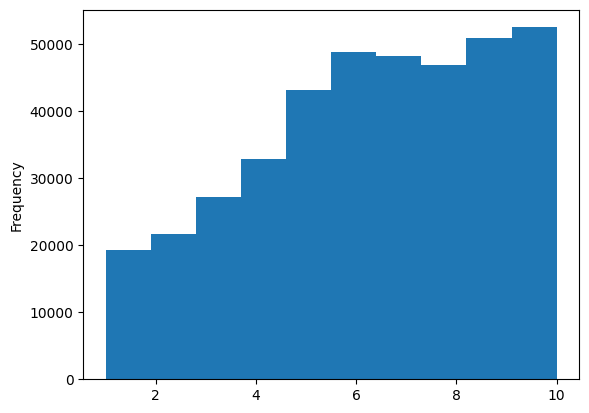

In [29]:
trip_df2['month'].plot.hist()

<Axes: ylabel='month'>

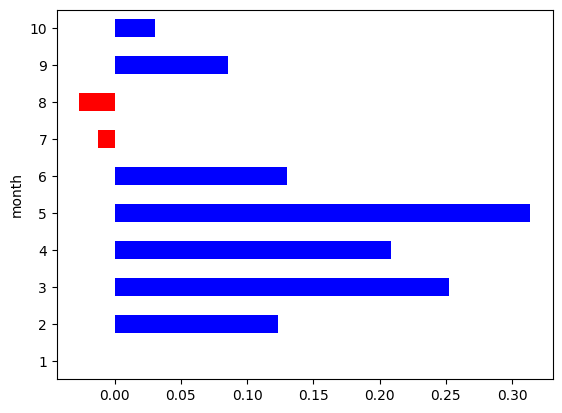

In [30]:
mom = trip_df2.groupby('month').count().iloc[:,1].pct_change()
mom.plot.barh(color=mom.apply(lambda x: 'blue' if x >=0  else 'red').values)

<Axes: ylabel='start_station_name'>

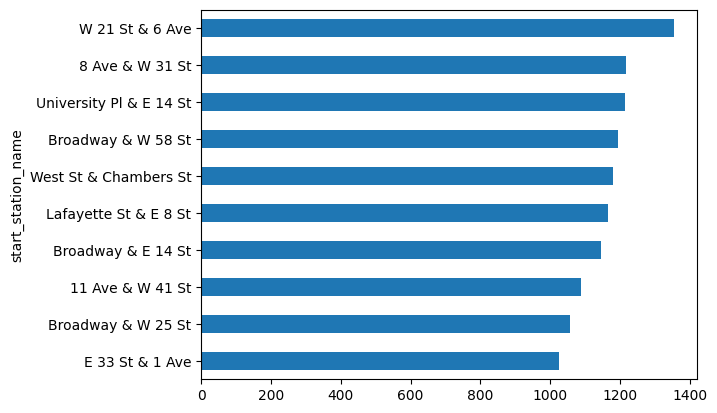

In [31]:
top_10_stations = trip_df2['start_station_name'].value_counts(ascending=True).iloc[-10::]
top_10_stations.plot.barh()

In [32]:
#Plot Heatmap
filtered_trip_df2 = trip_df2.query('start_station_name in @top_10_stations.index')
gdf = gpd.GeoDataFrame(filtered_trip_df2,
                       geometry=gpd.points_from_xy(filtered_trip_df2.start_lng, filtered_trip_df2.start_lat))
gdf.crs = "EPSG:4326"
m = folium.Map(location=[gdf['start_lat'].mean(), gdf['start_lng'].mean()], zoom_start=11)
heat_data = [[row['start_lat'], row['start_lng']] for index, row in filtered_trip_df2.iterrows()]
HeatMap(heat_data).add_to(m)
m.save('most_popular_start_stations.html')

In [33]:
m

array([<Axes: title={'center': '1'}, xlabel='hour'>,
       <Axes: title={'center': '2'}, xlabel='hour'>,
       <Axes: title={'center': '3'}, xlabel='hour'>,
       <Axes: title={'center': '4'}, xlabel='hour'>,
       <Axes: title={'center': '5'}, xlabel='hour'>,
       <Axes: title={'center': '6'}, xlabel='hour'>,
       <Axes: title={'center': '7'}, xlabel='hour'>], dtype=object)

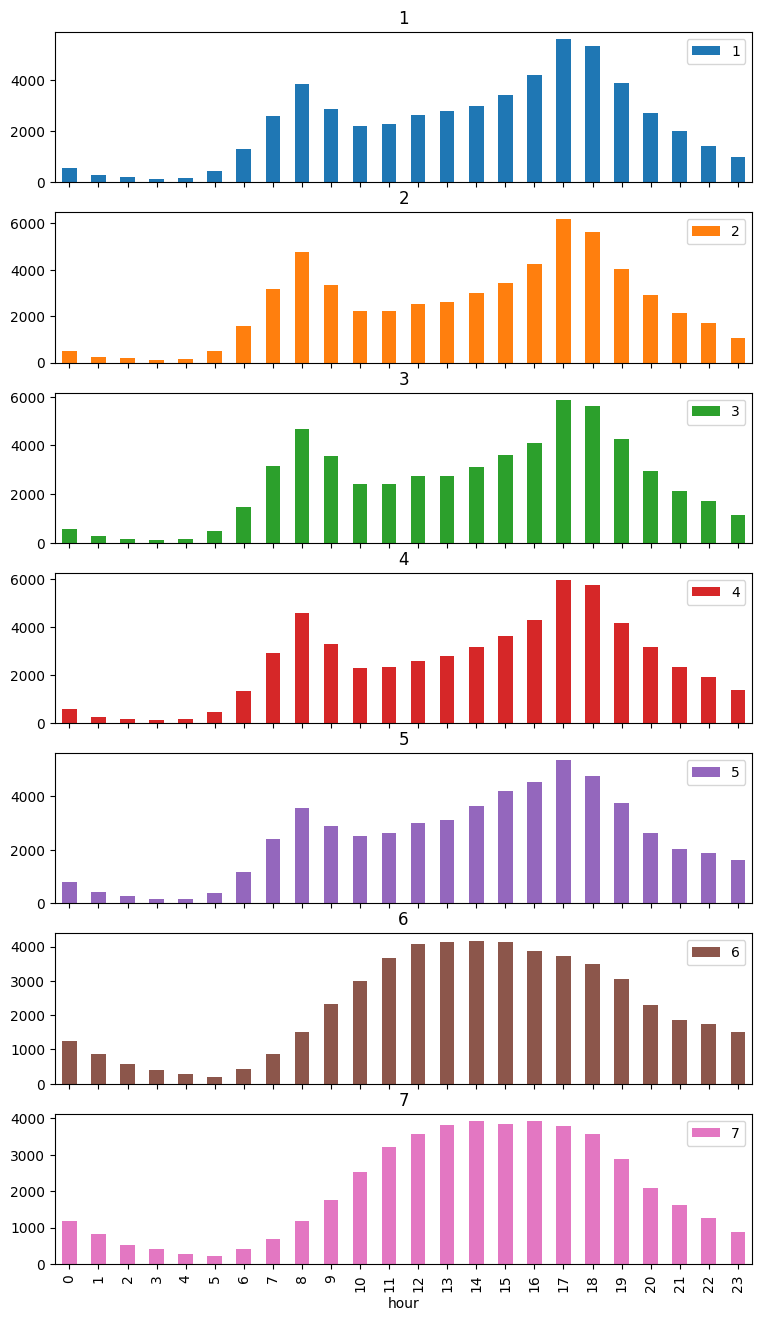

In [34]:
#Peak hours
trip_df2.groupby(['weekday','hour']).count().iloc[:,0].unstack('weekday').plot.bar(subplots=True, figsize=(9,16))

In [35]:
weather_df = pl.scan_csv('data/open-meteo-40.74N74.04W51m(3).csv', try_parse_dates=True, null_values = 'NaN').with_columns(time=pl.col('time').dt.cast_time_unit('ms'))
weather_df.head().collect()

time,temperature_2m_C,relative_humidity_2m_perc,precipitation_mm,weather_code,pressure_msl_hPa,cloud_cover_perc,wind_speed_10m_km_h,is_day
datetime[ms],f64,i64,f64,i64,f64,i64,f64,i64
2012-07-01 00:00:00,29.5,33,0.0,2,1007.4,70,8.6,1
2012-07-01 01:00:00,28.2,34,0.0,1,1008.1,23,10.1,0
2012-07-01 02:00:00,26.7,38,0.0,1,1008.5,21,10.5,0
2012-07-01 03:00:00,25.5,42,0.0,0,1008.8,18,10.1,0
2012-07-01 04:00:00,24.4,46,0.0,0,1008.9,4,9.7,0


# Modelling target location (regression)

In [36]:
def attach_weather_data(input_df: [pl.DataFrame, pl.LazyFrame]) -> [pl.DataFrame, pl.LazyFrame]:
    """
    Augments input_df with weather data loaded from file, matching timestamps based on closest hour. 
    """
    weather_df = pl.scan_csv('data/open-meteo-40.74N74.04W51m(3).csv', try_parse_dates=True, null_values = 'NaN').with_columns(time=pl.col('time').dt.cast_time_unit('ms'))
    return input_df.join(weather_df, left_on='closest_hour', right_on='time').drop('closest_hour')

There are some stations with very few rentals. If subsampling the data these will likely be missing in the training data. Fitting a classification model for the target station will be unsuccesful in that case. Thus we instead treat the problem as regression problem and try to predict the target location, which we can then be geocoded into a target station. Nonetheless there will be some areas underrepresented, this can really only be fixed by inclusion of more data from these areas from other years.

To reformulate this into a geospatial problem, we can predict the coordinates (latitude and longitude) of the end station rather than classifying it as a categorical station ID. By treating the task as a regression problem where the model predicts continuous geographic coordinates (latitude, longitude)

Finally, we can adjust the used a loss function such that the geographic distance between the predicted and true station locations is penalized, e.g. euclidean distance or Haversine distance (great-circle distance).

In [37]:
# scale lat/lon columns
geo_scaler = StandardScaler()
geo_scaler.fit(PER_STATION_LOC_MEAN.select(['lat', 'lng']).collect())

StandardScaler()

# base model on sample data

In [38]:
base_model_data = replace_station_locations_with_mean(trip_df)
base_model_data = attach_weather_data(base_model_data)
base_model_data = base_model_data.collect().to_pandas()
base_model_data = create_cyclic_time_features(base_model_data)
base_model_data, weather_scaler = normalize_weather_features(base_model_data)

In [39]:
X = base_model_data.drop(['lat_end', 'lng_end', 'end_station_name', 'ended_at'], axis=1)
y = geo_scaler.transform(base_model_data[['lat_end', 'lng_end']].set_axis(['lat','lng'], axis=1))
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)


dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True, nthread=4)

clf = xgb.train(params={"tree_method": "hist", "multi_strategy": "one_output_per_tree"}, dtrain=dtrain)

In [40]:
evaluate_loc_model(clf, X_test, y_test)

Mean Absolute Error: 0.01 grad
Root Mean Squared Error: 0.02 grad
Mean Euclidean Distance: 5.68 grad
Mean Haversine Distance: 2085.88 m
Maximum Predicted Distance: 235394.91 m


,0
0,1382.271240
1,1922.587036
2,1447.904785
3,616.049194
4,1697.178223
...,...
39168,521.546143
39169,2443.178711
39170,3784.559570
39171,665.990112


### Try custom objective function (Haversine Distance)

In [ ]:
TRAIN = True


# XGBoost parameters for out-of-core regression
params = {
    'tree_method': 'hist',  # Histogram-based tree construction
    'multi_strategy':'multi_output_tree',
    'num_target': 2,
    'eta': 0.1,
    'max_depth':6,
}

schema = {
        'rideable_type': pl.Categorical,
        'started_at': pl.Datetime,
        'ended_at': pl.Datetime,
        'start_station_name': pl.Categorical,
        'end_station_name': pl.Categorical,
        'member_casual': pl.Categorical,
    }

# init test set
X_test = pd.DataFrame()
y_test = pd.DataFrame()

num_boost_round = 150
bst = None
# Train the model incrementally on the batches
for i, file in enumerate(glob('data/*tripdata*.csv')):
    print(i, file)
    
    # Load batch data from CSV, could be reconfigured to read directly from AWS S3
    batch_data = pl.scan_csv(file, infer_schema_length=None, schema_overrides=schema, low_memory=True).select(list(schema.keys()))

    # subsample every 20th row (5% of data)
    batch_data.with_row_index().filter(pl.col("index")%20 == 1).drop("index")
    
    # pre-process
    batch_data = replace_station_locations_with_mean(batch_data)
    batch_data = augment_trip_data(batch_data)
    batch_data = attach_weather_data(batch_data)
    batch_data = batch_data.collect().to_pandas()
    
    X = batch_data.drop(['lat_end', 'lng_end', 'end_station_name', 'ended_at'], axis=1)
    y = geo_scaler.transform(batch_data[['lat_end', 'lng_end']].set_axis(['lat','lng'], axis=1))
    y = pd.DataFrame(y, columns= ['lat_end', 'lng_end'])
    X_train, X_test_batch, y_train, y_test_batch = train_test_split(X, y, test_size=0.05, random_state=SEED)

    X_test = pd.concat([X_test, X_test_batch])
    y_test = pd.concat([y_test, y_test_batch])

    # batch train
    if TRAIN:
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True, nthread=4)
        
        # Fit the model on this batch
        results: Dict[str, Dict[str, List[float]]] = {}
        if not bst:
            bst = xgb.train(
                params,
                dtrain,
                num_boost_round=num_boost_round,
                obj=haversine_loss,
                custom_metric=mean_haversine_distance,
                evals=[(dtrain, 'Train')],
                evals_result = results,
                verbose_eval=10,
            )
        else:
            bst = xgb.train(
                params,
                dtrain,
                num_boost_round=num_boost_round,
                obj=haversine_loss,
                custom_metric=mean_haversine_distance,
                evals=[(dtrain, 'Train')],
                evals_result = results,
                verbose_eval=10,
                xgb_model=bst,
            )
if TRAIN:
    bst.save_model('2024_xgboost_model_lat_lng_hd_m.json')
X_test.to_parquet('test_data.parquet')
y_test.to_parquet('test_labels.parquet')

0 data/202401-citibike-tripdata.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.44104	Train-mean_haversine_distance:69355.57812
[10]	Train-rmse:0.19052	Train-mean_haversine_distance:29936.89453
[20]	Train-rmse:0.12354	Train-mean_haversine_distance:19367.74414
[30]	Train-rmse:0.09191	Train-mean_haversine_distance:14364.05371
[40]	Train-rmse:0.07343	Train-mean_haversine_distance:11432.37402
[50]	Train-rmse:0.06131	Train-mean_haversine_distance:9504.07910
[60]	Train-rmse:0.05277	Train-mean_haversine_distance:8139.55957
[70]	Train-rmse:0.04643	Train-mean_haversine_distance:7124.14355
[80]	Train-rmse:0.04155	Train-mean_haversine_distance:6340.24658
[90]	Train-rmse:0.03770	Train-mean_haversine_distance:5717.96777
[100]	Train-rmse:0.03458	Train-mean_haversine_distance:5213.09082
[110]	Train-rmse:0.03202	Train-mean_haversine_distance:4796.20801
[120]	Train-rmse:0.02989	Train-mean_haversine_distance:4447.09814
[130]	Train-rmse:0.02809	Train-mean_haversine_distance:4151.20996
[140]	Train-rmse:0.02655	Train-mean_haversine_distance:3897.93457
[149]	Train-rmse

/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.02557	Train-mean_haversine_distance:3712.58032
[10]	Train-rmse:0.02442	Train-mean_haversine_distance:3520.56470


# Evaluate Models

In [ ]:
bst = xgb.Booster()
bst.load_model('2024_xgboost_model_lat_lng_hd_m.json')

In [ ]:
evaluate_model(bst)

In [ ]:
print(pd.DataFrame(distances).describe())
pd.DataFrame(distances).plot.hist(bins=200)


So the model performs quite well on average, however we notice the distribution beiing extremely skweed. There are a few outliers where the prediction is way off, these are likely trips which were underrepresented in the data set (as noted earlier).

In [ ]:
# plot predictions with accuracy up to 2km
import matplotlib.pyplot as plt
true_locs = geo_scaler.inverse_transform(y_test[distances < 2000])
pred_locs = geo_scaler.inverse_transform(preds[distances < 2000])

plt.figure(figsize=(10, 6))
plt.scatter(x=true_locs[:,0], y=true_locs[:,1], label='True Locations', alpha=0.5, s=10)
plt.scatter(x=pred_locs[:,0], y=pred_locs[:,1], label='Predicted Locations', alpha=0.5, s=10)
plt.title('True vs Predicted Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

This visual points towards a systemic error in the model building pipeline with the haversine distance, likely the gradient computation is erroneous.